In [1]:
import scvelo as scv
import scanpy as sc, numpy as np, pandas as  pd, anndata as ad

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=150, frameon=False)

# Step 1: Load Data

In [3]:
adata = sc.read_h5ad('../data/processed/cells_postprocessed.h5ad')

In [4]:
# load loom files for spliced/unspliced matrices
ldata = scv.read('../data/processed/Pituitary_velocyto_all.loom', cache=True)
ldata.var_names_make_unique()

In [5]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

In [11]:
cort = adata[adata.obs.cell_type_brief == "Cort"]
cort = cort[cort.obs.treat.isin(['Saline','LPS','Poly(i:c)'])]

# Step 2: Pre-processing

In [12]:
sc.pp.normalize_total(cort, target_sum=1e4)
sc.pp.log1p(cort)
sc.pp.highly_variable_genes(cort, min_mean=0.0125, max_mean=3, min_disp=0.5)
cort.raw = cort
cort = cort[:, cort.var.highly_variable]
sc.pp.regress_out(cort, ['nCount_RNA'])
sc.pp.scale(cort, max_value=10)

In [13]:
sc.tl.pca(cort, svd_solver='arpack')
sc.pp.neighbors(cort, n_neighbors=15, n_pcs=50)
sc.tl.umap(cort)

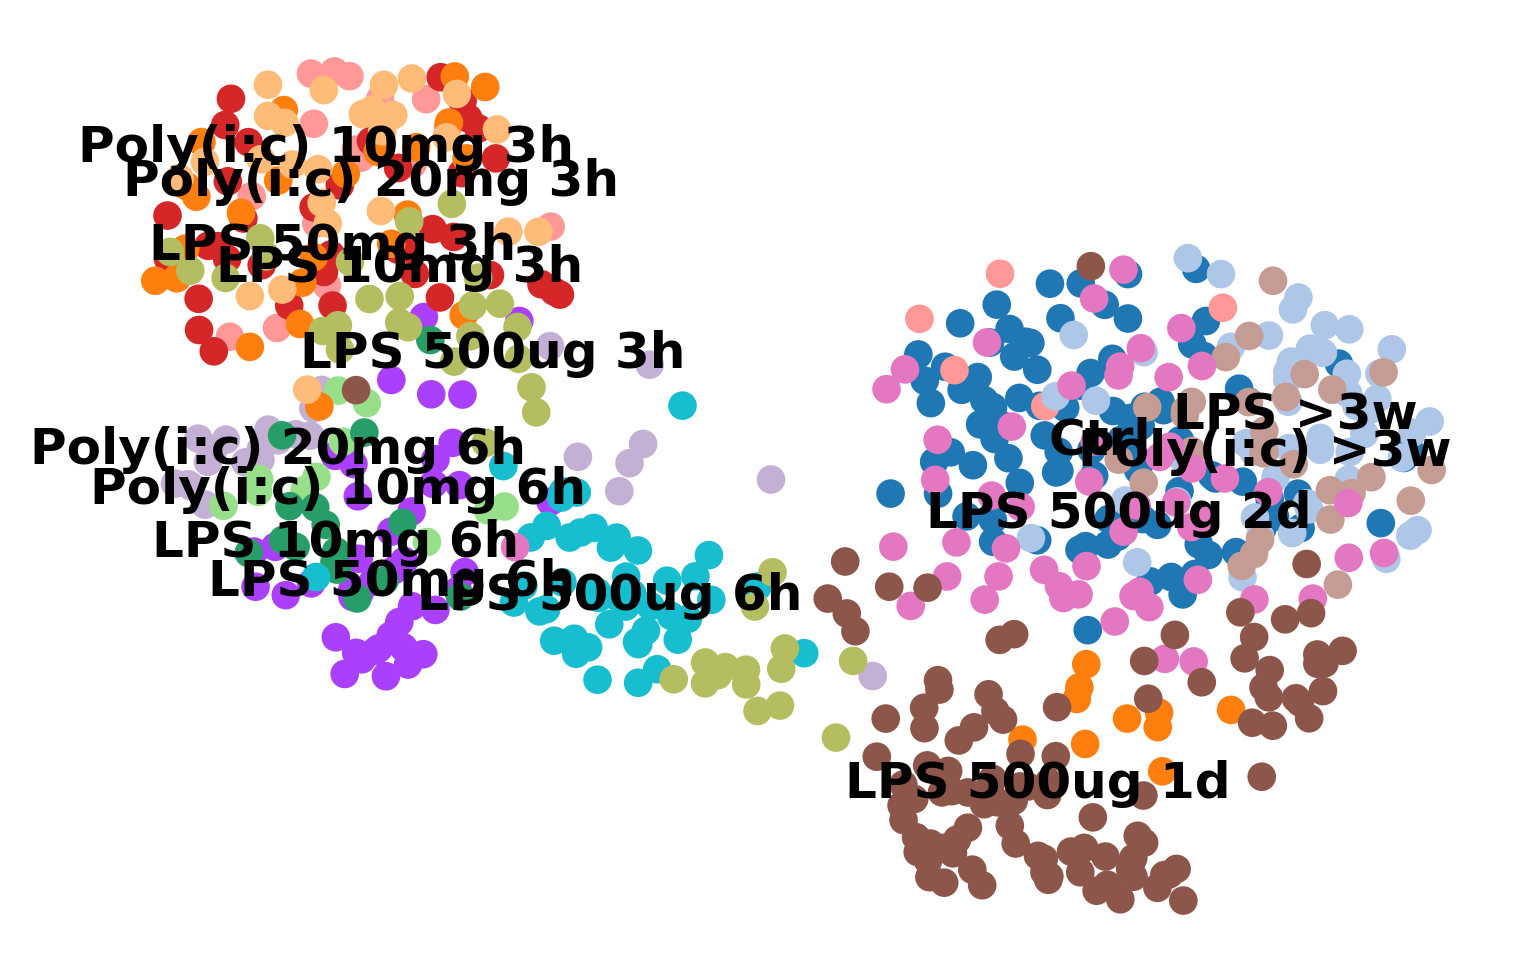

In [14]:
# plot umap to check
sc.pl.umap(cort, color=['stim'], frameon=False, legend_loc='on data', title='')

# Step 3: Computing RNA velocity using scVelo
## Step 3-1: Steady-state model

In [15]:
# pre-process
scv.pp.filter_and_normalize(cort)
scv.pp.moments(cort)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
# compute velocity using the steady-state model (La Manno., 2018), i.e. mode='stochastic'
scv.tl.velocity(cort, mode='stochastic')
scv.tl.velocity_graph(cort)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/636 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_cort_pca_embedding_grid.pdf


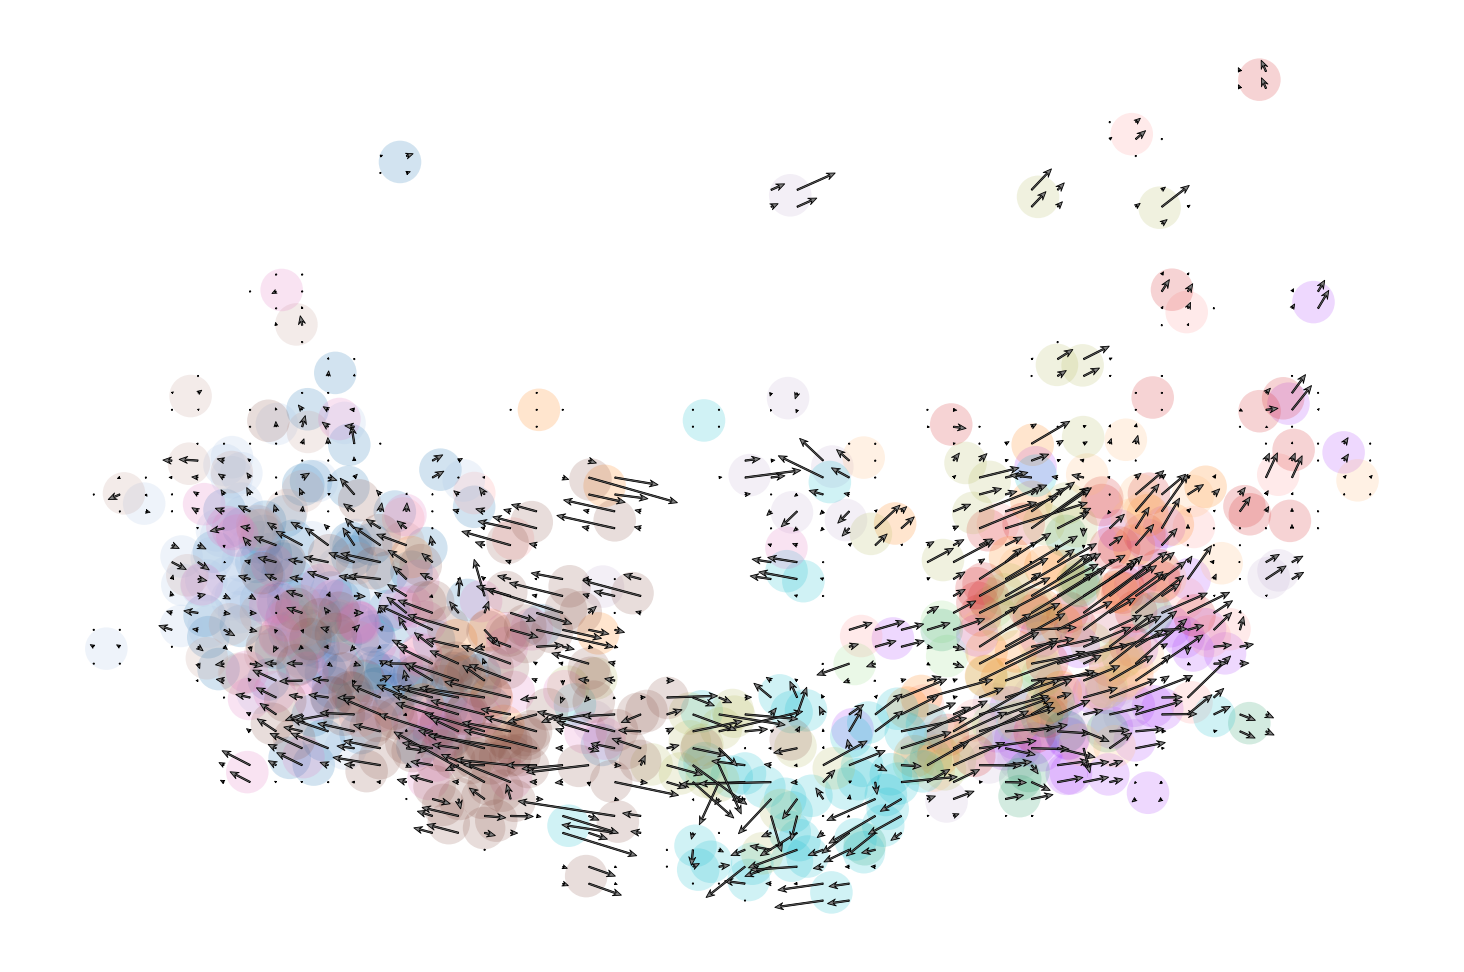

In [17]:
scv.pl.velocity_embedding_grid(cort, basis='pca', color='stim', save='cort_pca_embedding_grid.pdf', title='', scale=0.25)

saving figure to file ./figures/scvelo_cort_pca_embedding_stream.png


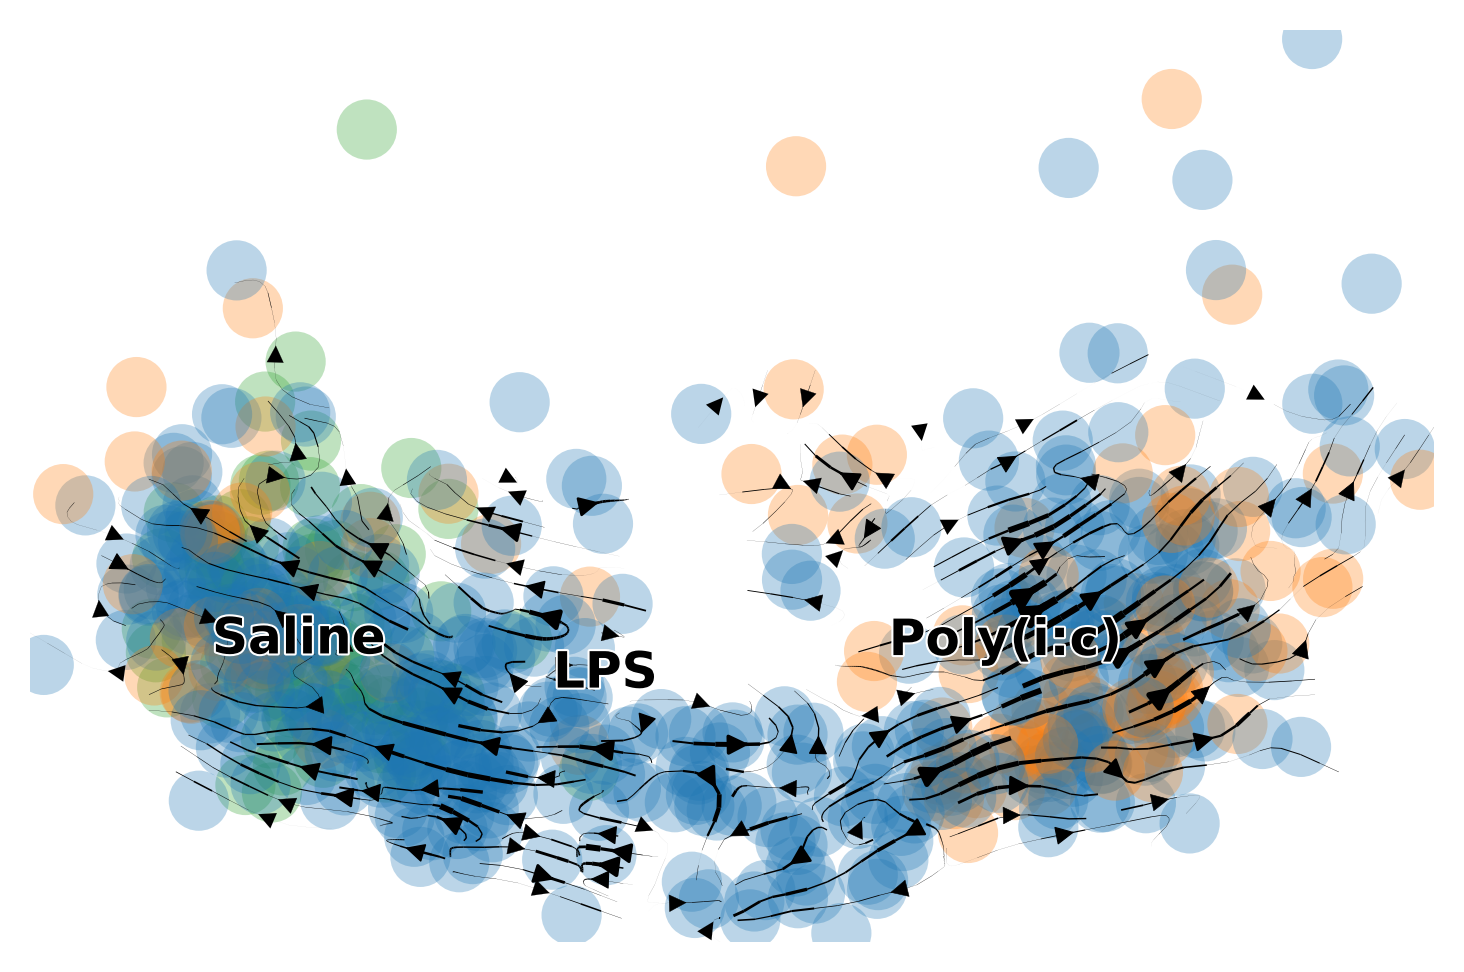

In [19]:
scv.pl.velocity_embedding_stream(cort, basis='pca', color=['treat'], save='cort_pca_embedding_stream.png', title='')

## Step 3-2: Dynamic model

In [20]:
sc.tl.pca(cort, svd_solver='arpack')
sc.pp.neighbors(cort, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(cort)

In [21]:
# pre-process
scv.pp.filter_and_normalize(cort)
scv.pp.moments(cort)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [22]:
scv.tl.recover_dynamics(cort, n_jobs=16)

recovering dynamics (using 16/48 cores)


  0%|          | 0/139 [00:00<?, ?gene/s]

    finished (0:00:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [23]:
# compute velocity using the dynamical model (Bergen., 2020), i.e. mode='dynamical'
scv.tl.velocity(cort, mode='dynamical')
scv.tl.velocity_graph(cort)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/636 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


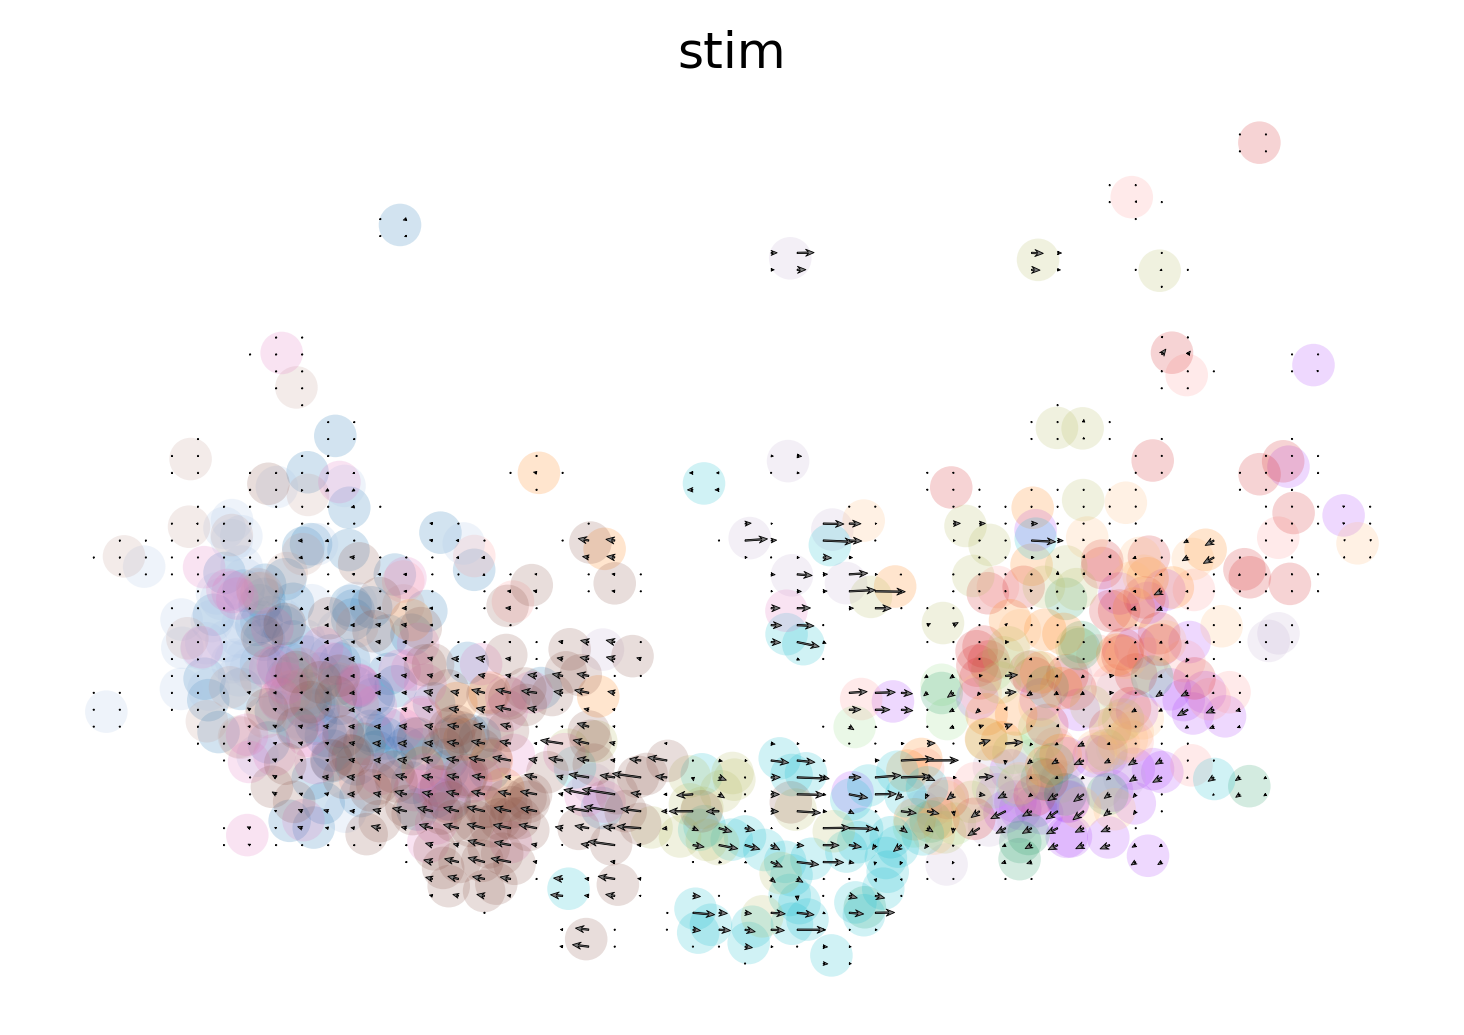

In [24]:
scv.pl.velocity_embedding_grid(cort, basis='pca',color='stim')

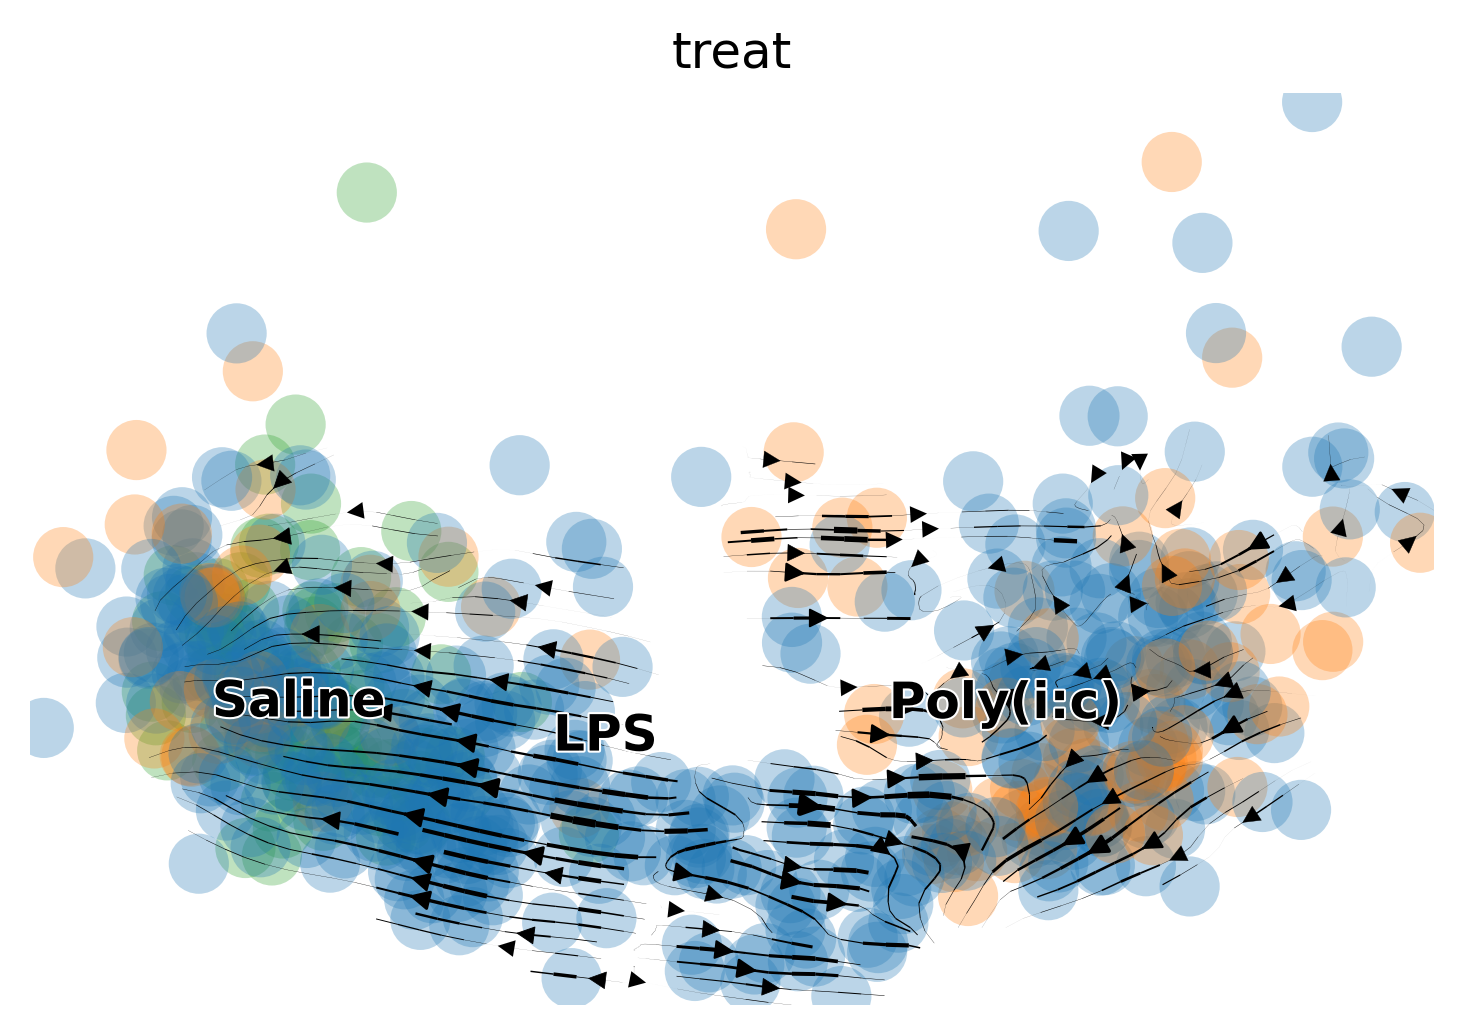

In [26]:
scv.pl.velocity_embedding_stream(cort, basis='pca',color='treat')